In [1]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

In [2]:
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
X = X.values
y = y.astype(int).values

In [3]:
X.shape, y.shape

((70000, 784), (70000,))

In [4]:
X = ((X / 255.0) - 0.5) * 2

In [5]:
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=10000, random_state=123, stratify=y)
X_train, X_valid, y_train, y_valid = train_test_split(X_temp, y_temp, test_size=5000, random_state=123, stratify=y_temp)

In [6]:
import NeuralNet

In [7]:
model = NeuralNet.NeuralNetMLP(num_features=28*28, num_hidden=50, num_classes=10)

In [8]:
num_epochs = 50
minibatch_size = 100
def minibatch_generator(X, y, minibatch_size):
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)
    for start_idx in range(0, indices.shape[0] - minibatch_size + 1, minibatch_size):
        batch_idx = indices[start_idx: start_idx + minibatch_size]
        yield X[batch_idx], y[batch_idx]

In [9]:
for i in range(num_epochs):
    minibatch_gen = minibatch_generator(X_train, y_train, minibatch_size)
    for X_train_mini, y_train_mini in minibatch_gen:
        break
    break

X_train_mini.shape, y_train_mini.shape

((100, 784), (100,))

In [14]:
def mse_loss(targets, probas, num_labels=10):
    onehot_targets = NeuralNet.int_to_onehot(targets, num_labels=num_labels)
    return np.mean((onehot_targets - probas)**2)

def accuracy(targets, predicted_labels):
    return np.mean(predicted_labels == targets)

In [16]:
_, probas = model.forward(X_valid)
mse = mse_loss(y_valid, probas)
mse

0.27072877992538014

In [18]:
predicted_labels = np.argmax(probas, axis=1)
acc = accuracy(y_valid, predicted_labels)
acc

0.0936

In [20]:
def compute_mse_and_acc(nnet, X, y, num_labels=10, minibatch_size=100):
    mse, correct_pred, num_examples = 0, 0, 0
    minibatch_gen = minibatch_generator(X, y, minibatch_size)
    for i, (features, targets) in enumerate(minibatch_gen):
        _, probas = nnet.forward(features)
        predicted_labels = np.argmax(probas, axis=1)
        onehot_targets = NeuralNet.int_to_onehot(targets, num_labels=num_labels)
        loss = np.mean((onehot_targets - probas)**2)
        correct_pred += (predicted_labels == targets).sum()
        num_examples += targets.shape[0]
        mse += loss

    mse /= i + 1
    acc = correct_pred / num_examples
    return mse, acc

In [24]:
mse, acc = compute_mse_and_acc(model, X_valid, y_valid)
mse, acc

(0.27072877992538014, 0.0936)

In [38]:
def train(model, X_train, y_train, X_valid, y_valid, num_epochs, learning_rate=0.1):
    epoch_loss = []
    epoch_train_acc = []
    epoch_valid_acc = []
    for e in range(num_epochs):
        minibatch_gen = minibatch_generator(X_train, y_train, minibatch_size)
        for X_train_mini, y_train_mini in minibatch_gen:
            a_h, a_out = model.forward(X_train_mini)
            d_loss__d_w_out, d_loss__d_b_out, d_loss__d_w_h, d_loss__d_b_h = model.backward(X_train_mini, a_h, a_out, y_train_mini)
            model.weight_h -= learning_rate * d_loss__d_w_h
            model.bias_h -= learning_rate * d_loss__d_b_h
            model.weight_out -= learning_rate * d_loss__d_w_out
            model.bias_out -= learning_rate * d_loss__d_b_out

        train_mse, train_acc = compute_mse_and_acc(model, X_train, y_train)
        valid_mse, valid_acc = compute_mse_and_acc(model, X_valid, y_valid)
        epoch_train_acc.append(train_acc)
        epoch_valid_acc.append(valid_acc)
        epoch_loss.append(train_mse)

    return epoch_loss, epoch_train_acc, epoch_valid_acc

In [40]:
np.random.seed(123)
epoch_loss, epoch_train_acc, epoch_valid_acc = train(model, X_train, y_train, X_valid, y_valid, num_epochs=50, learning_rate=0.1)

In [42]:
epoch_loss, epoch_train_acc, epoch_valid_acc

([0.05014174840677177,
  0.031231413449715608,
  0.024361729655085894,
  0.020853996016582273,
  0.018774723537522308,
  0.017422905834689605,
  0.016381316109997244,
  0.01554283722330267,
  0.01483317549065623,
  0.014252545844277714,
  0.013796097496164679,
  0.013376372510499324,
  0.013039476041693275,
  0.012683129551983767,
  0.012372070519630426,
  0.012111924042822061,
  0.011880047411648186,
  0.01160010970263164,
  0.011436291806580736,
  0.011194787511687634,
  0.010992647186455597,
  0.010801996004904656,
  0.010620976084596025,
  0.010475875672878146,
  0.010401651524256528,
  0.010181771332876472,
  0.010045082285845008,
  0.00986907022090333,
  0.009741059813899956,
  0.009615161403837773,
  0.009502872196817742,
  0.0094336090881937,
  0.009379226104539349,
  0.009175439966537814,
  0.009081983816158656,
  0.008974427623039235,
  0.008880244463180864,
  0.008771729655542878,
  0.008664943576940412,
  0.008593424940100881,
  0.008502936746531957,
  0.00843199087072645,


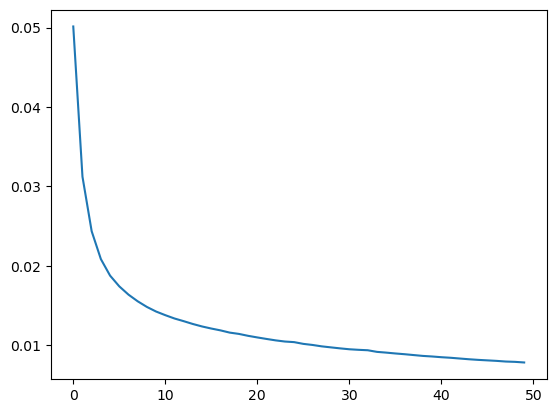

In [44]:
plt.plot(range(len(epoch_loss)), epoch_loss)
plt.show()

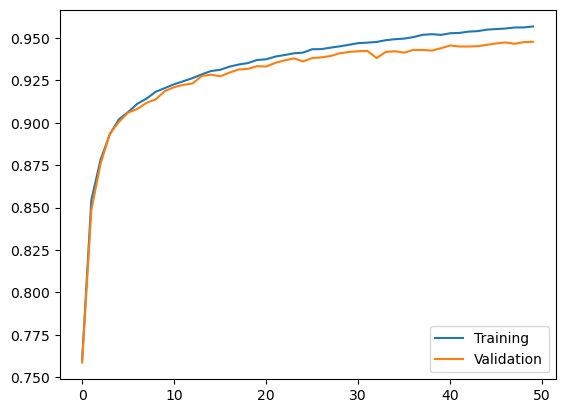

In [46]:
plt.plot(range(len(epoch_train_acc)), epoch_train_acc, label='Training')
plt.plot(range(len(epoch_valid_acc)), epoch_valid_acc, label='Validation')
plt.legend(loc='lower right')
plt.show()

In [50]:
test_mse, test_acc = compute_mse_and_acc(model, X_test, y_test)
test_acc

0.9469

In [ ]:
fig, ax = plt.subplots(nrows=5, ncols=5, sharex=True, sharey=True)
ax = ax.flatten()
for i in range(25):
    imp = X[y == 7][i].reshape(28, 28)
    ax[i].imshow(imp, cmap='Greys')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

In [52]:
X_test_subset = X_test[:1000, :]
y_test_subset = y_test[:1000]
_, probas = model.forward(X_test_subset)
test_pred = np.argmax(probas, axis=1)
misclassified_images = X_test_subset[y_test_subset != test_pred][:25]
misclassified_labels = test_pred[y_test_subset != test_pred][:25]
correct_labels = y_test_subset[y_test_subset != test_pred][:25]

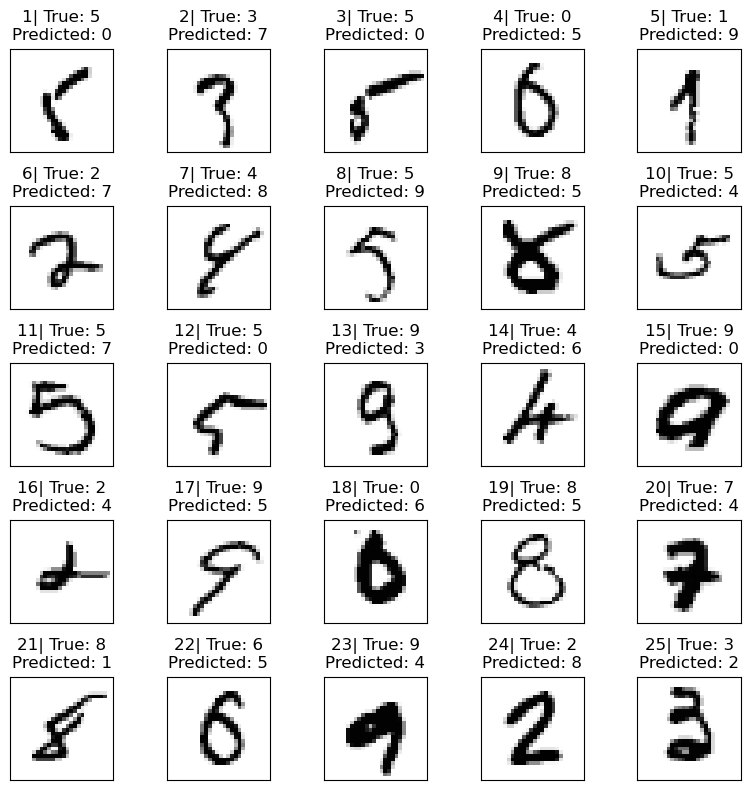

In [56]:
fig, ax = plt.subplots(nrows=5, ncols=5, sharex=True, sharey=True, figsize=(8, 8))
ax = ax.flatten()
for i in range(25):
    img = misclassified_images[i].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys', interpolation='nearest')
    ax[i].set_title(f'{i+1}| True: {correct_labels[i]}\nPredicted: {misclassified_labels[i]}')
ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()